# **Laporan Proyek UAS Kecerdasan Buatan**
#### Dosen Pengampuh: Lucas E. Suryana, M.T.

## Kelompok 3:

*   Noel Christevent M.  - 10101200436 
*   Christopher K.S.     - 10101190155
*   Edgar Tigor          - 10101190203



#  **Tugas 1 - Computer Vision**

Pendahuluan:

Dimasa pandemi ini, pemerintah sangat menekankan masyarakat untuk mematuhi prinsip 5M, yaitu:


*   Memakai masker
*   Mencuci tangan
*   Menjaga jarak
*   Menjauhi kerumunan
*   Membatasi mobilitas

Hal ini bertujuan untuk mengurangi penyebaran kasus COVID-19 di Indonesia. Kami merasa protokol kesehatan khususnya memakai masker masih sering dilanggar. Oleh karena itu pada kesempatan ini, kami membuat sebuah model yang dapat mendeteksi apakah seseorang menggunakan masker atau tidak. Berikut adalah langkah-langka pengerjaan yang kelompok kami lakukan.




## **1. Mengimport library yang diperlukan**
Dalam sebagian besar pembuatan model, kami menggunakan *library* TensorFlow. *Library* Keras kami butuhkan untuk membuat *model check point* yang menyimpan model dengan akurasi tertinggi kemudian memanggilnya kembali. Numpy dan Matplotlib kami gunakan untuk menampilkan visualisasi *history* pelatihan dan hasil prediksi model. Kami menggunakan *library* Time untuk mencatat waktu pelatihan model. Kami menggunakan *library* Sklearn untuk menampilkan *confusion matrix*.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import callbacks
from keras import models
from sklearn.metrics import confusion_matrix

## **2. Persiapan data**
Dalam melatih model *computer vision* ini, kami membutuhkan banyak foto orang menggunakan masker dan tidak menggunakan masker beserta dengan labelnya untuk melatih model. 

Kami menggunakan data latih yang berisi 7553 gambar yang sudah dilabeli dari situs Kagle.
https://www.kaggle.com/omkargurav/face-mask-dataset

Sebagai data validasinya, kami menggunakan foto peserta kelas Kecerdasan Buatan sejumlah 27 gambar yang sudah dilabeli.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir_train = '/content/drive/MyDrive/Colab Notebooks/UAS_AI/Data'
data_dir_val = '/content/drive/MyDrive/Colab Notebooks/UAS_AI/data_kelas'
batch_size = 32
img_height = 100
img_width = 100

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7553 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_val,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


### Melihat Visualisasi data awal

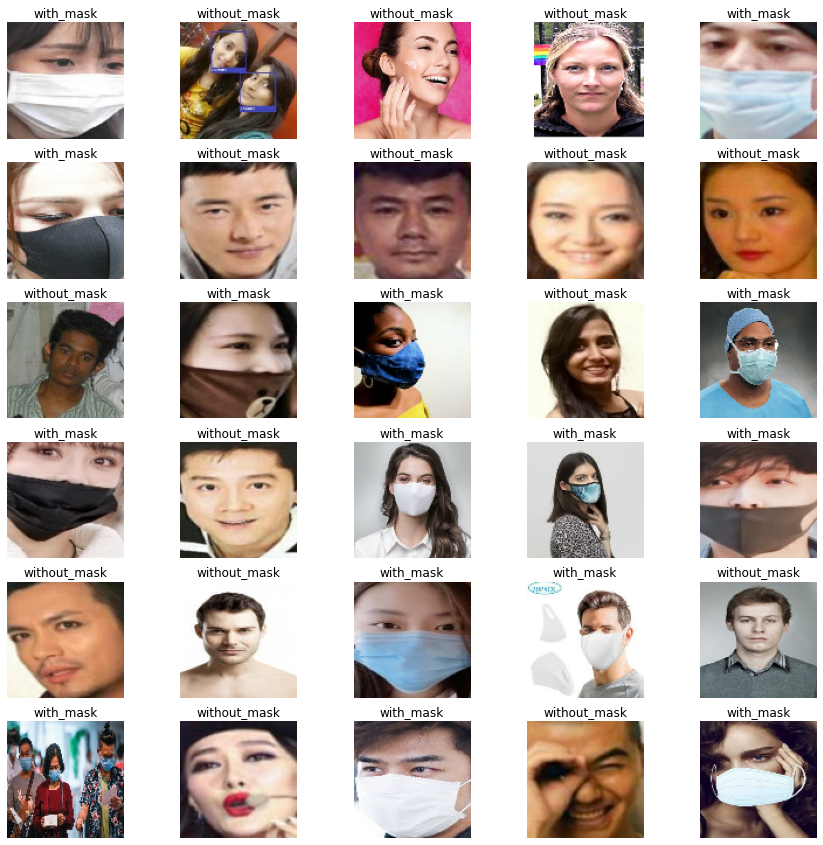

In [ ]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(30):
    ax = plt.subplot(6,5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


### Melakukan augmentasi data untuk meningkatkan akurasi model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

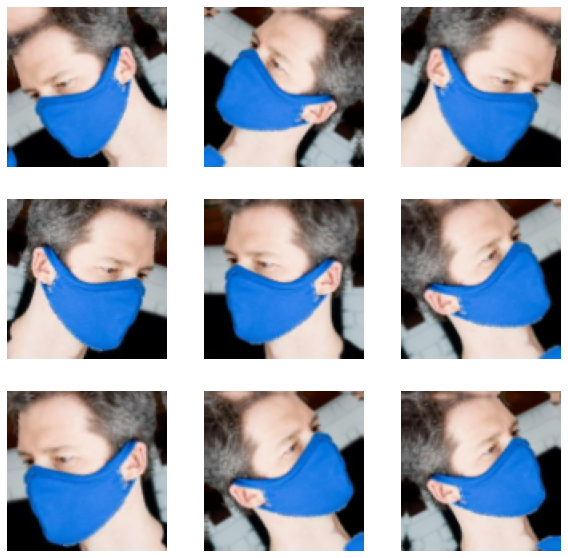

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

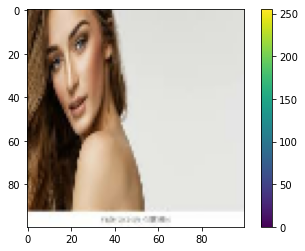

In [ ]:
for images, labels in train_ds.take(1):
  plt.figure()
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.colorbar()
  plt.grid(False)
  plt.show()

## **3. Mempersiapkan Model**
Kami membuat *model sequential* dengan tahapan sebagai berikut:
* Melakukan augmentasi gambar
* Melakukan normalisasi atau *rescalling*
* Melakukan Tiga kali tahapan konfolusi dan *max pooling*
* Melakukan *Flattening* gambar
* Memasukan hasilnya kedalam *fully conected layer* dengan dua hidden layer yang memiliki fungsi aktivasi relu.
* Memasukan kedalam layer terakhir yang terdiri dari dua output dengan fungsi aktivasi softmax agar asilnya dalam bentuk persentasi.

Kami juga menggunakan *Sparse Categorical Crossentropy* sebagai *lost function* untuk permasalahan klasifikasi, dan *model check point* untuk menyimpan model dengan akurasi tertinggi.

In [ ]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1/255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(100, activation='relu'),
  layers.Dense(100, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)       

In [ ]:
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

## **4. Melatih Model**
Pada tahap ini, kami melatih model dengan *epochs* sebanyak 30. Dari hasil *model check point*, model dengan akurasi terbaik ada pada *epoch* ke 24.
Tahapan pelatihan ini akan jauh lebih lama dari pada tahapan-tahapan lain. Waktu eksekusi model kami sekitar setengah jam.

In [ ]:
start = time.time()
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[mc]
)
end = time.time()
print('waktu pelatihan',(end-start)/60,'menit')

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


237/237 [==============================] - 1122s 5s/step - loss: 0.3408 - accuracy: 0.8517 - val_loss: 0.6256 - val_accuracy: 0.8889

Epoch 00001: val_accuracy improved from -inf to 0.88889, saving model to best_model.h5
Epoch 2/30
237/237 [==============================] - 17s 71ms/step - loss: 0.2453 - accuracy: 0.9026 - val_loss: 0.6433 - val_accuracy: 0.8519

Epoch 00002: val_accuracy did not improve from 0.88889
Epoch 3/30
237/237 [==============================] - 18s 76ms/step - loss: 0.1911 - accuracy: 0.9285 - val_loss: 0.7382 - val_accuracy: 0.8519

Epoch 00003: val_accuracy did not improve from 0.88889
Epoch 4/30
237/237 [==============================] - 18s 76ms/step - loss: 0.1683 - accuracy: 0.9378 - val_loss: 0.6350 - val_accuracy: 0.8519

Epoch 00004: val_accuracy did not improve from 0.88889
Epoch 5/30
237/237 [==============================] - 19s 78ms/step - loss: 0.2136 - accuracy: 0.9174 - val_loss: 0.5459 - val_accuracy: 0.8519

Epoch 00005: val_accuracy did not 

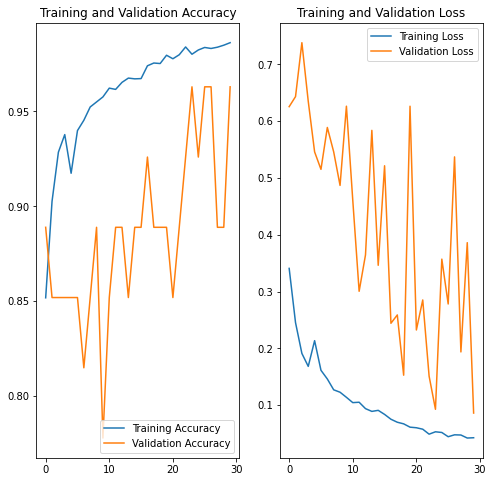

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
best_model = models.load_model('best_model.h5')

## Lihat hasil prediksi model

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i].numpy().astype("uint8")
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array[i])
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("pred: {} (asli: {})".format(class_names[predicted_label],
                                class_names[true_label]),
                                color=color)

In [ ]:
 # Deklarasikan fungsi untuk melakukan visualisasi gambar yang akan membantu kita di dalam memahami dari nilai prediksi
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i].numpy().astype("uint8")
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array[i])
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array[i]),
                                class_names[true_label]),
                                color=color)
  
def plot_value_array(i, predictions_label, true_label, class_names):
  true_label = int(true_label[i])
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_label[i], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_label[i])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

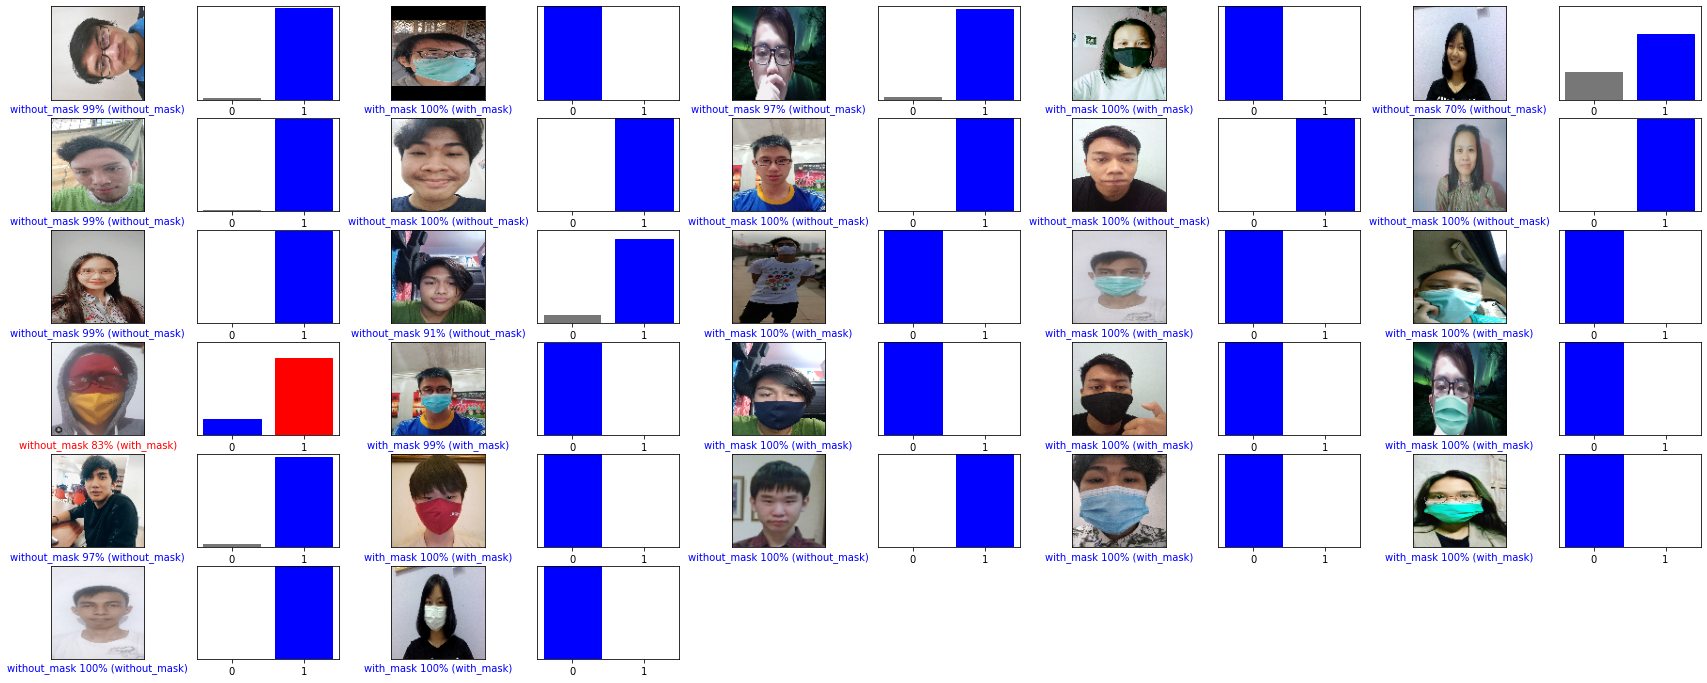

In [ ]:
num_rows = 6
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 2*num_rows))
for images, labels in val_ds.take(1):
  pred = model.predict(images)
  y_true = labels
  y_pred = np.argmax(pred, axis=-1)
  for i in range(num_rows*num_cols):    
    #print(pred[i])
    if i == 27:
      break
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, pred, labels, images)
    #plt.imshow(images[i].numpy().astype("uint8"))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i,pred, labels, class_names)


In [ ]:
confusion_matrix(y_true, y_pred)

array([[13,  1],
       [ 0, 13]])

## Analisa:<br>
Berdasalkan hasil uji pada data validasi, model kami bisa mengklasifikasi hampir semua foto peserta kelas kecerdasan buatan memakai masker atau tidak. Model ini juga 'percaya diri' dengan hasil klasifikasinya karena hampir semua hasilnya diatas 90% bahkan sebagian besar 100%. Menurut kami, model ini agak ragu dalam mengklasifikasi foto di paling kanan atas (foto Valen) karena terdapat bayangan yang mencolok pada bagian leher yang hampir dideteksi sebagai masker. Kemudian ada foto yang salah ditebak model, hal ini memang bukan foto menggunakan masker dengan baik karena orang dalam foto tersebut menggunakan dua masker. Namun karena kesalan klasifikasi tersebut ada pada bagian False Positif tidak terlalu berbahaya. Kesalahan klasifikasi berbahaya ada saat foto orangnya tidak menggukan masker tetapi dideteksi memakai masker (False Negative) karena akan berpotensi menyebarkan Covid-19.

## Kesimpulan:
Kami sudah berhasil membuat model klasifikasi penggunaan masker berdasarkan foto dengan hasil pengujian hasil klasifikasi yang sangat baik dengan akurasi sebesar 96%. Walaupun ada salah satu gambar yang tidak tepat diklasifikasi, hal ini tidak masalah karena kesalahannya bukan *False Negative*. 
## Saran:
* Saat menunggu pelatihan model dengan *google colabs*, kami sarankan jangan terlalu lama ditinggal karena bisa *disconect* dan harus menjalankan lagi dari awal.<br>
* Lebih baik menggunakan GPU agar pelatihan model *computer vision* menjadi lebih cepat. Saat tanpa GPU waktu pelatihan model kami bisa sampai 2 jam, tetapi dengan GPU waktu pelatihan model bisa berkurang manyak menjadi 30 menit.

# **Tugas 2 - Natural Language Processing**

## Latar Belakang:
Di dalam masa pandemi ini, terutama di dalam beberapa bulan terakhir banyak terjadi topik-topik menarik terkait Covid-19. Kami menggunakan NLP untuk mengambil dan menganalisis komentar dari Twitter. Hal ini diperlukan agar kami mengetahui respon yang diberikan terkait suatu topik dan respon tersebut akan bermanfaat dalam mengambil keputusan selanjutnya baik untuk keperluan politik ataupun bisnis.

## 1. Persiapan Library yang Dibutuhkan

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 19.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993223 sha256=bbf6e0f2d23c37f463b88905ab0cfd2f3df0d53750c6f86a29fc8fb0349f5b86
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 2. Autentikasi Twitter

In [ ]:
# Authentication
consumerKey = '398CFhjDeUtvqr5hTst0Mj6Zb'
consumerSecret ='xwBhnGYvyLkWjL3vIShGTSa1dPbWxk28dUxswDiaL6q88v6pJu'
accessToken = '1393937049917399040-onzgrEzq28abboUAGJ49Pq80yCgRlz'
accessTokenSecret = 'Y0vNc4FKtONCgGOQCbYjvKYz9f3kSWVtLBqVFTWh5rVxj'
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
SentimentIntensityAnalyzer().polarity_scores('quite good')

{'compound': 0.4927, 'neg': 0.0, 'neu': 0.238, 'pos': 0.762}

## 3. Mengambil 100 tweet dengan kata kunci "lost job during covid-19"

In [ ]:
#Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)
keyword = input('Please enter keyword or hashtag to search: ')
noOfTweet = int(input ('Please enter how many tweets to analyze: '))
#tweets = tweepy.Cursor(api.search, q=keyword).items(noOfTweet)
tweets = api.search(q=keyword, count = noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets:
 
 #print(tweet.text)
 tweet_list.append(tweet.text)
 analysis = TextBlob(tweet.text)
 score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 polarity += analysis.sentiment.polarity
 
 if neg > pos:
     negative_list.append(tweet.text)
     negative += 1
 elif pos > neg:
     positive_list.append(tweet.text)
     positive += 1
 
 elif pos == neg:
     neutral_list.append(tweet.text)
     neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Please enter keyword or hashtag to search: lost job during covid-19
Please enter how many tweets to analyze: 100


In [ ]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

total number:  100
positive number:  3
negative number:  94
neutral number:  3


## 4. Visualisasi Persentasi Sentimen Masyarakat Berdasarkan 100 Tweet

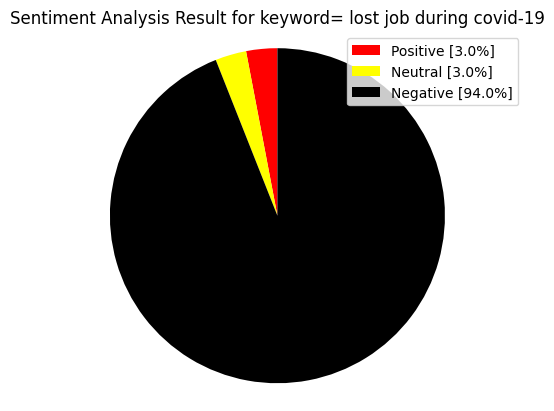

In [ ]:
#Creating PieCart
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['red', 'yellow','black']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis Result for keyword= '+keyword+'' )
plt.axis('equal')
plt.show()

Lihat contoh kalimat tweet

In [ ]:
tweet_list

0
0   RT @DanPriceSeattle: Sources: \n1. What worker...
1   7 Steps To Take If You’ve Lost Your Job During...
2   Millions of Americans have lost their jobs. Be...
3   RT @uma_vasudeva: My father lost his job last ...
4   Effects of COVID-19 on the economy during the ...
..                                                ...
95  My father lost his job last year due to Covid ...
96  RT @Dharmen97099095: @KamalaHarris  Mam I am f...
97  RT @Diana_monkey: "This is the story of a rura...
98  RT @Diana_monkey: "This is the story of a rura...
99  RT @BAMPI: My neighbor that lost her job durin...

[100 rows x 1 columns]

## 5. Cleaning Text

In [ ]:
tweet_list.drop_duplicates(inplace = True)

In [ ]:
#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list['text'] = tw_list[0]
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: ','',x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",x)
tw_list['text'] = tw_list.text.map(remove_rt).map(rt)
tw_list['text'] = tw_list.text.str.lower()
tw_list.head(10)

0                                               text
0  RT @DanPriceSeattle: Sources: \n1. What worker...  sources   1  what workers have lost   2  what ...
1  7 Steps To Take If You’ve Lost Your Job During...  7 steps to take if you ve lost your job during...
2  Millions of Americans have lost their jobs. Be...  millions of americans have lost their jobs  be...
3  RT @uma_vasudeva: My father lost his job last ...  my father lost his job last year due to covid ...
4  Effects of COVID-19 on the economy during the ...  effects of covid 19 on the economy during the ...
5  @METROFMSA #Takealot10thBirthday (part 1)\nMy ...     takealot10thbirthday  part 1  my most memor...
6  RT @uma_vasudeva: My father lost his job last ...  my father lost his job last year due to covid ...
7  RT @uma_vasudeva: My father lost his job last ...  my father lost his job last year due to covid ...
8  RT @uma_vasudeva: My father lost his job last ...  my father lost his job last year due to covid ...
9  RT @uma_vasudeva: My father lost his job last ...  my father lost his job last year due to covid ...

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
 score = SentimentIntensityAnalyzer().polarity_scores(row)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 if neg > pos:
  tw_list.loc[index, 'sentiment'] = 'negative'
 elif pos > neg:
  tw_list.loc[index, 'sentiment'] = 'positive'
 else:
  tw_list.loc[index, 'sentiment'] = 'neutral'
  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp
tw_list.head(10)

0  ... compound
0  RT @DanPriceSeattle: Sources: \n1. What worker...  ...      NaN
1  7 Steps To Take If You’ve Lost Your Job During...  ...      NaN
2  Millions of Americans have lost their jobs. Be...  ...      NaN
3  RT @uma_vasudeva: My father lost his job last ...  ...      NaN
4  Effects of COVID-19 on the economy during the ...  ...      NaN
5  @METROFMSA #Takealot10thBirthday (part 1)\nMy ...  ...      0.0
6  RT @uma_vasudeva: My father lost his job last ...  ...      NaN
7  RT @uma_vasudeva: My father lost his job last ...  ...      NaN
8  RT @uma_vasudeva: My father lost his job last ...  ...      NaN
9  RT @uma_vasudeva: My father lost his job last ...  ...      NaN

[10 rows x 9 columns]

In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

Total  Percentage
negative     94        94.0
neutral       3         3.0
positive      3         3.0

## 6. Membuat Wordcloud

In [ ]:
#Function to Create Wordcloud
def create_wordcloud(text):
 mask = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/UAS_AI/cloud.png"))
 stopwords = set(STOPWORDS)
 wc = WordCloud(background_color='white',
 mask = mask,
 max_words=3000,
 stopwords=stopwords,
 repeat=True)
 wc.generate(str(text))
 wc.to_file('wc.png')
 print('Word Cloud Saved Successfully')
 path='wc.png'
 display(Image.open(path))

### Sentimen positif

Word Cloud Saved Successfully


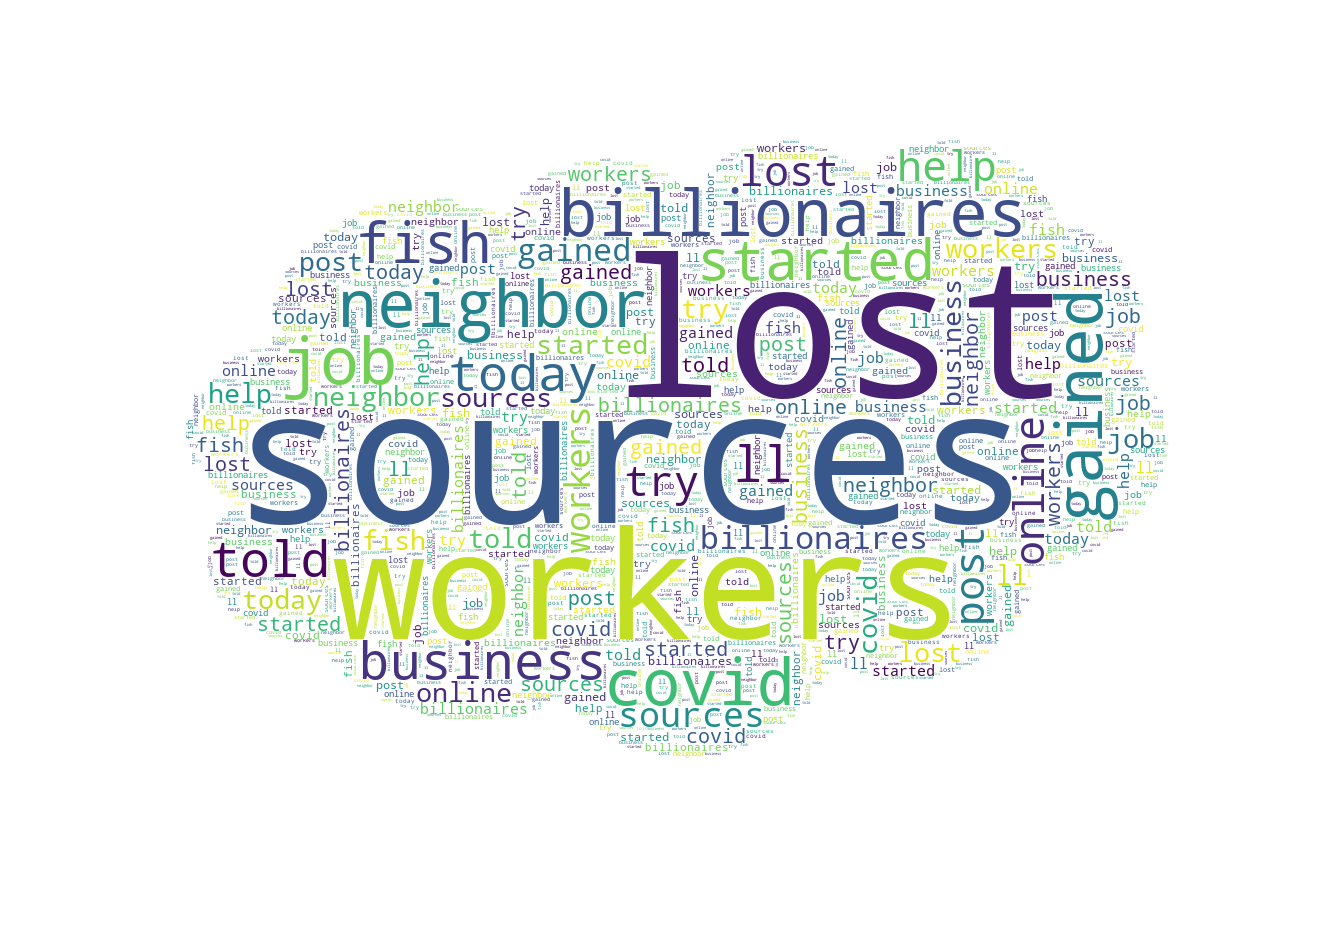

In [ ]:
#Creating wordcloud for positive tweets
create_wordcloud(tw_list_positive['text'].values)

### Sentimen negatif

Word Cloud Saved Successfully


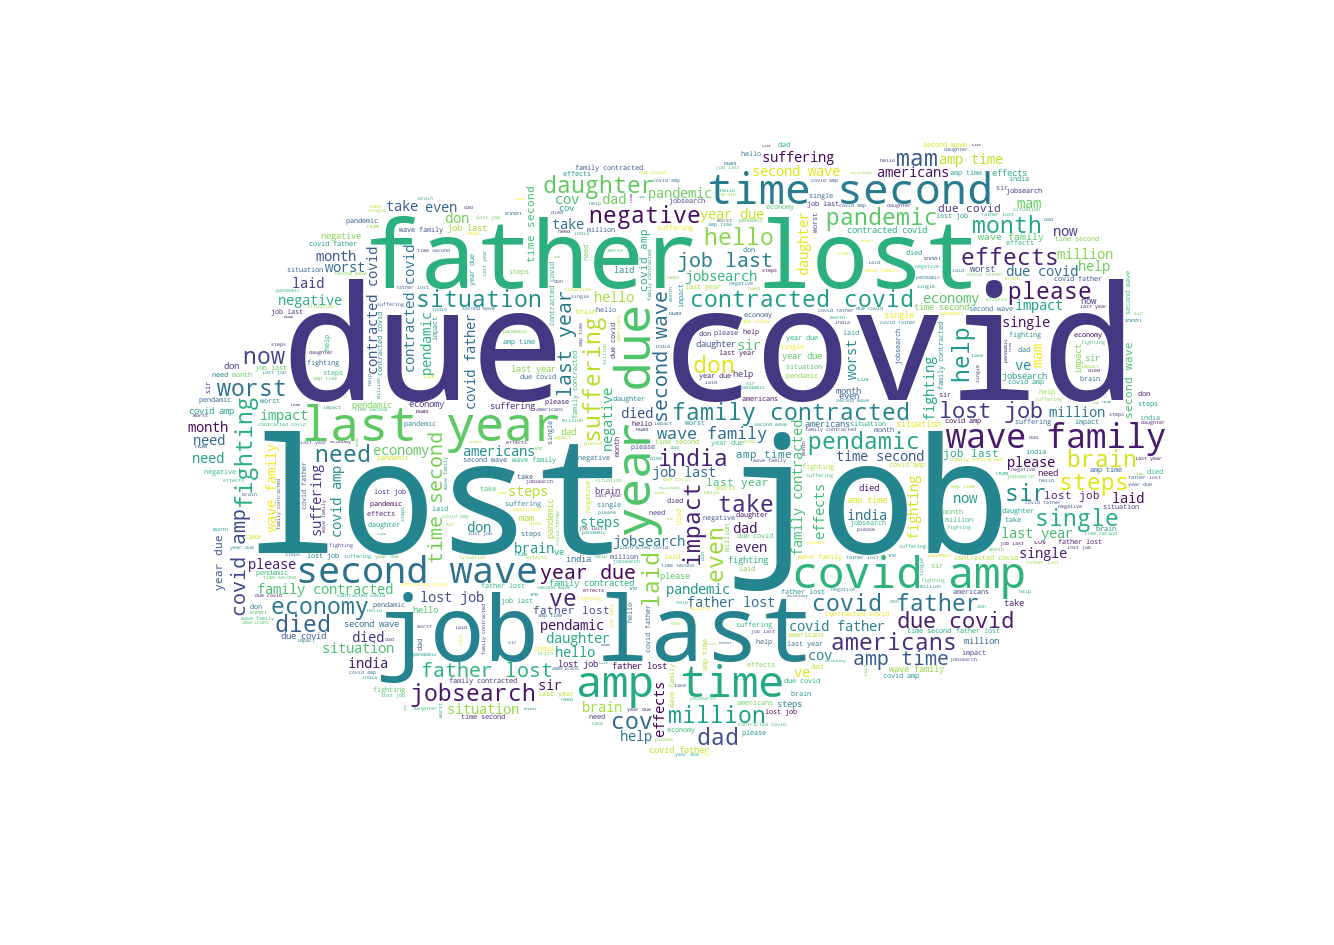

In [ ]:
#Creating wordcloud for negative sentiment
create_wordcloud(tw_list_negative['text'].values)

### Sentimen netral

Word Cloud Saved Successfully


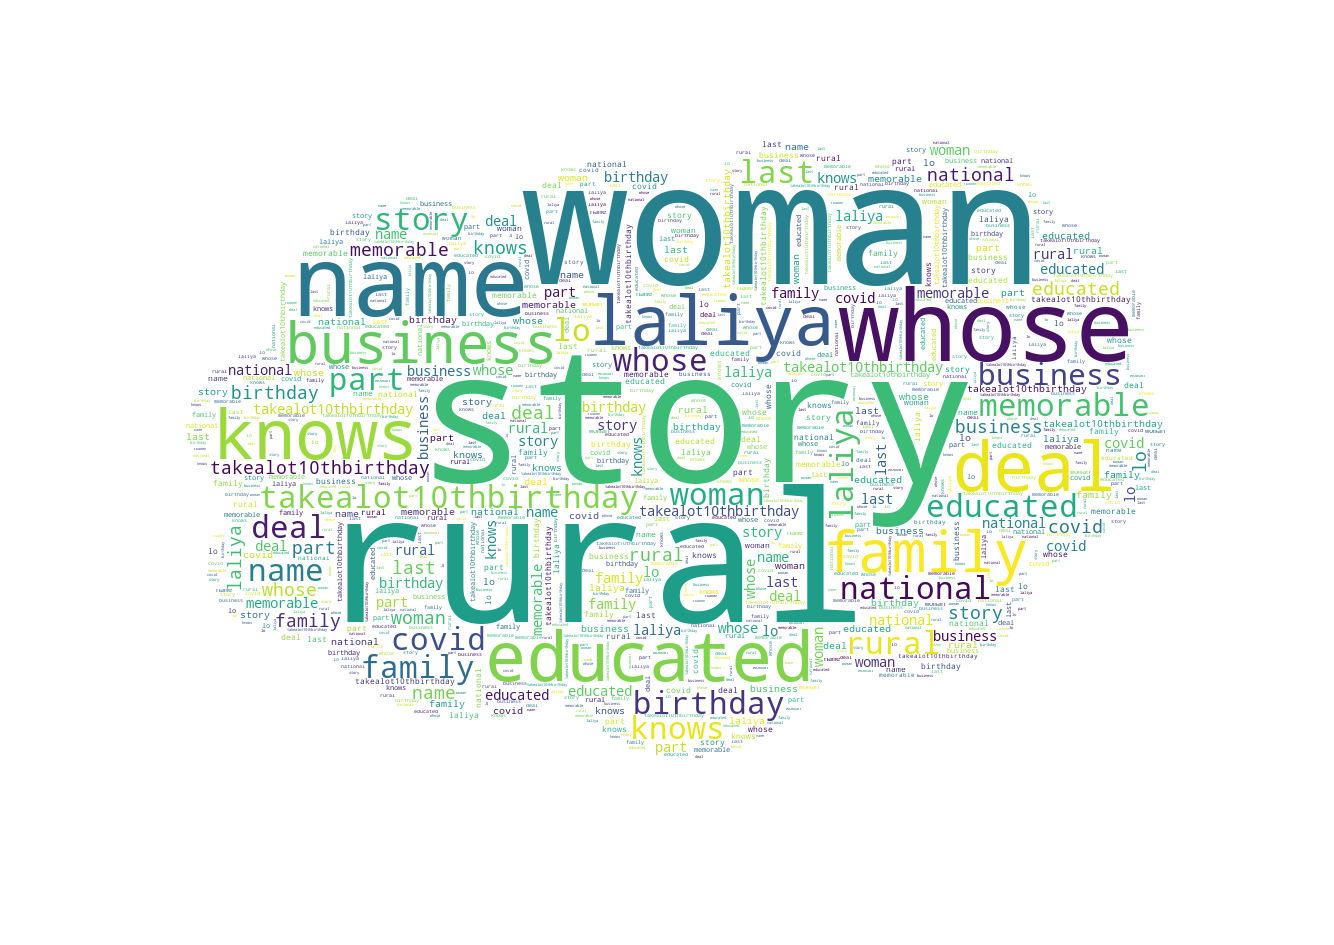

In [ ]:
#Creating wordcloud for neutral sentiment
create_wordcloud(tw_list_neutral['text'].values)

## **7. Laporan :**



1.  **Ringkasan singkat** <br>
Berdasarkan hasil diskusi yang kelompok kami lakukan, kelompok kami sepakat untuk mengambil kata kunci “lost job during covid-19”. Alasan kami memilih kata kunci tersebut adalah karena di masa pandemik ini perekonomian mengalami penurunan maka agar perusahaan dapat menstabilkan keuangan mereka, banyak dari pekerja kehilangan pekerjaan mereka (di phk). Sehingga melalui kata tersebut, kami bisa melihat respon apa saja yang diberikan oleh responden terkait kata “lost job during covid-19”.



2.   Dibawah ini adalah gambar persentase dari 100 data yang diambil. <br>
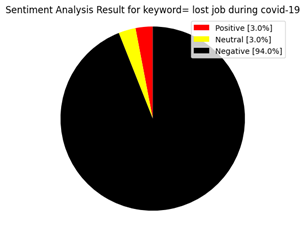


*   Dibawah ini adalah kata-kata yang bersifat positif:

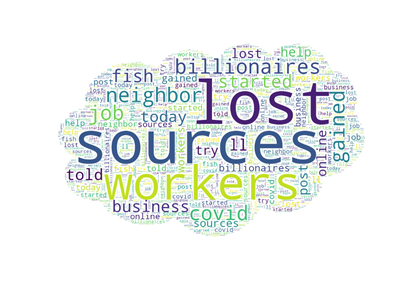


*   Dibawah ini adalah kata-kata yang bersifat negatif:

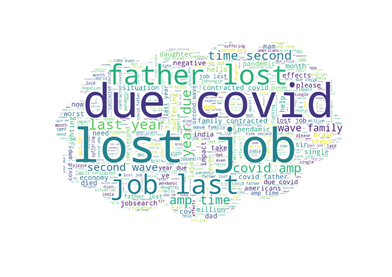

*   Dibawah ini adalah kata-kata yang bersifat neutral:

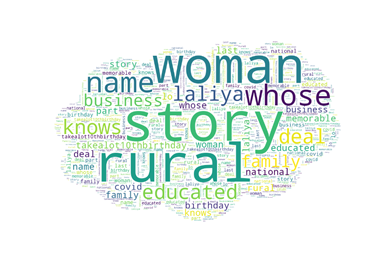



3.   **Penjelasan:** <br>
Dari 3% kalimat positif yang ditemukan, kata yang menyebabkan tweet tersebut memiliki konotasi kata yang bersifat positif adalah workers,gained,started,business,billionaires,try.<br>
Contoh: *My neighbor that lost her job during Covid-19 started her fish business today.*<br><br>
Dari 94% kalimat negatif yang ditemukan, kata yang menyebabkan tweet tersebut memiliki konatasi kata yang bersifat negatif adalah lost job, covid, family, pendamic, job search.<br>
Contoh: *Millions of Americans have lost their jobs. Being laid off for just a few months can have a negative impact on your…*<br><br>
Dari 3% kalimat neutral yang ditemukan, kata yang menyebabkan tweet tersebut memiliki konotasi kata yang bersifat neutral adalah birthday, national, woman, name, laliya.<br>
Contoh: *Takealot10thbirthday  part 1  my most memorable birthday story was last during the covid 19 national ...*



# **Kesimpulan dan Saran**

**Kesimpulan**

Dari hasil pencarian sentimen analisis didapatkan kesimpulan bahwa setiap kali program dijalankan akan mengeluarkan hasil presentase yang selalu berubah. Baik itu sentimen positif, sentimen negatif maupun sentimen neutral. Bukan hanya presentase yang berubah melainkan ada beberapa kata atau kalimat yang berubah.

**Saran**

Jumlah tweets yang didapatkan berdasarkan keywords tidak terbatas pada 100 sentimen agar hasil yang didapatkan lebih akurat.

# **Tugas 3 - Reinceforment Learning**

Di masa pandemi ini, salah satu hal yang diwajibkan ketika berpergian antar kota bahkan negara adalah swab test. swab test digunakan untuk memeriksa seseorang, apakah orang tersebut mengidap penyakit covid atau tidak. Test ini dilakukan dengan cara mengambil lendir dari hidung atapun tenggorakan dengan alat seperti *cutton bud*. Biasanya akan terasa sakit atau kurang nyaman saat melakukan swab test. Dalam melakukan test ini, petugas Kesehatan juga lebih beresiko tertular covid. Untuk mengatasi masalah yang sangat serius tersebut, diciptakannya suatu robot yang berfungsi untuk melakukan swab test.

Robot swab test tersebut dilatih menggunakan reinforcement learning yang diuji cobakan kepada para relawan. Dalam pelatihan tersebut, robot ini belajar untuk dapat melakukan swab yang lembut dan nyaman. Robot ini juga diperlengkapi dengan sensor dan juga kamera untuk mengetahui respon dari pasien.  salah satu hal yang paling penting selain dapat melakukan swab test dengan lembut dan nyamanan, robot ini juga befungsi untuk mengurangi penularan covid kepada petugas Kesehatan.Jadi tidak adanya interaksi langsung antara pasien dengan petugas kesehatan sehingga dengan cara ini penularan covid dapat dikurangkan. Selain itu, proses swab test menggunakan robot bisa dua kali lebih cepat dibandingkan dengan swab manual. 


###Bagian Reinforcement:
Agen = robot <br>
Lingkungan = hidung / tenggorakan pasien <br>
Reward = respon pasien <br>
Punish = respon pasien (-) <br>
State = posisi *cutton bud* <br>
Action = mengubah posisi *cutton bud* <br>



# **Contoh visualisasi Swab Robot**


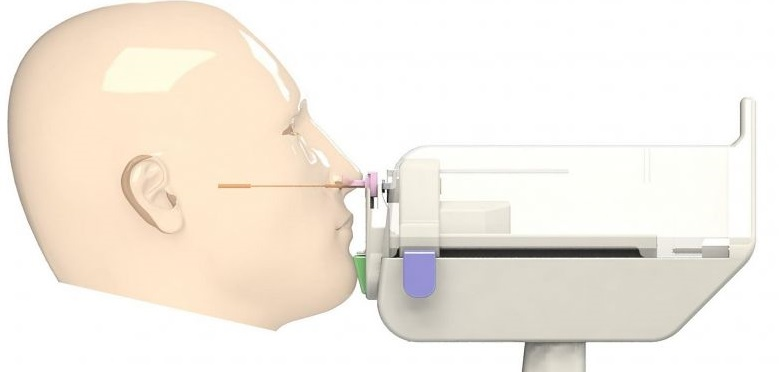

# **Kesimpulan**

Di dalam proyek Reinforcement Learning, kita dapat melihat manfaat yang sangat luar biasa dari reinforcement learning, dimana diciptakannya suatu robot swab test yang sangat bermanfaat bagi pasien dan juga petugas kesehatan yaitu dengan mengurangi presentase penyebaran covid akibat adanya interaksi antara pasien dengan petugas kesehatan. Lalu untuk pasien sendiri di dalam melakukan swab test dapat dilakukan disaat mereka merasa siap serta proses saat melakukan swab test lebih nyaman,tidak sakit dan lebih cepat. Sehingga dengan adanya swab robot tersebut membuat tingkat penyebaran covid-19 dapat berkurang serta penggunaanya lebih efisien.



# Referensi:

https://www.tensorflow.org/tutorials/images/classification

https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d

https://www.alodokter.com/cara-kerja-tes-pcr-dalam-mendeteksi-virus-dan-bakteri

https://www.liputan6.com/global/read/4362132/dokter-di-singapura-kembangkan-robot-swab-test-covid-19-prosesnya-hanya-20-detik




# Komitmen Integritas:
“Di hadapan TUHAN yang hidup, saya menegaskan bahwa saya tidak memberikan maupun menerima bantuan apa pun—baik lisan, tulisan, maupun elektronik—di dalam ujian ini selain daripada apa yang telah diizinkan oleh pengajar, dan tidak akan menyebarkan baik soal maupun jawaban ujian kepada pihak lain.”